In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.vision.all import show_image, show_images
from datasets import load_dataset

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

from tinyai.core import inplace, def_device, to_device, collate_ds
from tinyai.training import fit, cross_entropy
from tinyai.conv import conv

In [ ]:
dsd = load_dataset("daloopa/fashion-mnist-interview")
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
})

In [ ]:
x,y = 'image','label'

In [ ]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)

<Axes: >

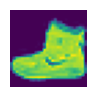

In [ ]:
show_image(tds['train'][0][x])

In [ ]:
cf = collate_ds(tds['train'])
def collate_(b): return to_device(cf(b))

In [ ]:
def dataloaders(dsd, bs, **kwargs): return {k: DataLoader(v, batch_size=bs, **kwargs) for k,v in dsd.items()}

In [ ]:
dls = dataloaders(tds, bs=256, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [ ]:
labels = tds['train'].features[y].names; labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
xb.shape

torch.Size([256, 1, 28, 28])

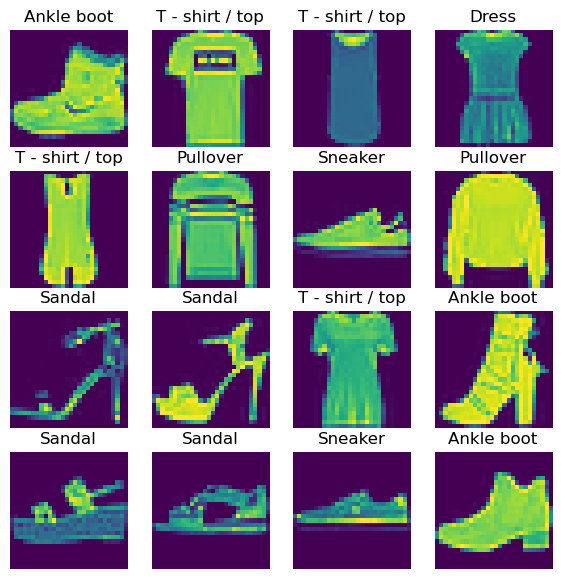

In [ ]:
def i2o(yb): return [labels[o] for o in yb]
    
show_images(xb[:16], nrows=4, ncols=4, titles=i2o(yb[:16]), figsize=(7,7))

In [ ]:
# same as before
cnn = nn.Sequential(
    conv(1, 4),               # 14x14
    conv(4, 8),               # 7x7
    conv(8, 16),              # 4x4
    conv(16, 16),             # 2x2
    conv(16, 10, act=False),
    nn.Flatten()
).to(def_device)

In [ ]:
xb, yb = next(iter(dt))
xb.shape, yb.shape, yb.ndim

(torch.Size([256, 1, 28, 28]), torch.Size([256]), 1)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=0.2)
fit(3, cnn, cross_entropy, dt, dv, opt)

Epoch 0:


/Users/tom/fun/tinyai/tinyai/training.py:32: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


Val Loss: 0.8239 Val Accuracy: 0.7086
Epoch 1:
Val Loss: 0.6905 Val Accuracy: 0.7488
Epoch 2:
Val Loss: 0.5428 Val Accuracy: 0.8114


# Autoencoder

In [ ]:
def deconv(fi, fo, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
     nn.Conv2d(fi, fo, kernel_size=ks, stride=1, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)


In [ ]:
ae = nn.Sequential(    # 28x28
    nn.ZeroPad2d(2),   # 32x32
    conv(1,2),         # 16x16
    conv(2,4),         # 8x8
    conv(4,8),         # 4x4
    deconv(8,4),       # 8x8
    deconv(4,2),       #16x16
    deconv(2,1),       #32x32
    nn.ZeroPad2d(-2)   #28x28
).to(def_device)

In [ ]:
import torch
import torch.nn.functional as F

def accuracy(xb, yb): return (xb.argmax(1) == yb).float().mean()

def eval(model, loss_func, valid_dl, epoch):
    model.eval()
    with torch.no_grad():
        vloss = []
        for xb, _ in valid_dl:
            xb_pred = model(xb)
            vloss.append(loss_func(xb_pred, xb))
        print(f"Epoch {epoch}: Total loss: {sum(vloss)/len(vloss):.4f}")

def fit(epochs, model, loss_func, train_dl, valid_dl, opt):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            xb_pred = model(xb)
            loss = loss_func(xb_pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        eval(model, loss_func, valid_dl, epoch)


opt = optim.AdamW(ae.parameters(), lr=2e-3)
fit(3, ae, F.mse_loss, dt, dv, opt)

Epoch 0: Total loss: 0.1242
Epoch 1: Total loss: 0.1242
Epoch 2: Total loss: 0.1242


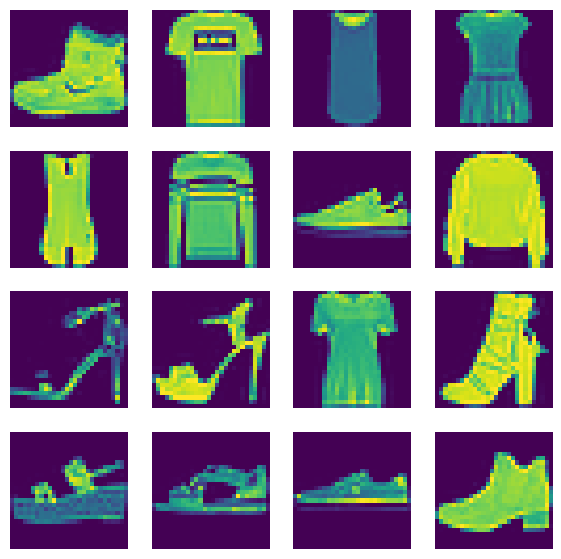

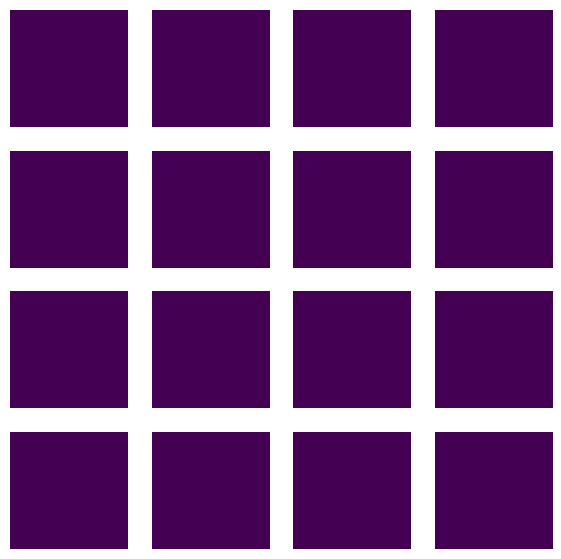

In [ ]:
show_images(xb[:16], nrows=4, ncols=4, figsize=(7,7))
show_images(ae(xb[:16]), nrows=4, ncols=4, figsize=(7,7))

Not so close :/